# DSC-680 Applied Data Science
## Project #1 -  Analyzing and Predicting Weight Loss

By Ambrose M Malagon Cordero
___________

**Data Sets**

The following data sets were used for the preparation of this project:

1. omada_weight.txt - My weight as tracked by the Omada Health weight program. The data was copied from the Omada website and then pasted into the *omada_weight.txt* file.

2. food_med_data.xlsx - My tracked meals, medication and miscellenous information. 

Both datasets are available in this GibHut repository for replication purposes. Please check the Project documentation PDF for full details regarding these files.


_____________________
## Data Preparation


In [88]:
# Libraries and dependencies used for this project

import pandas as pd     # Use DataFrames and associated functionality
import numpy as np      # Use for numpy associated functionality such as date/delta time calculations
import matplotlib.pyplot as plt     # For visualizations
import seaborn as sns       # For additonal visualization functionality
from yellowbrick.features import Rank2D     # Generates Pearson's ranking
from sklearn.model_selection import train_test_split    # Split data into training and validation sets
from sklearn.preprocessing import StandardScaler        # Scale predictor variables
from sklearn.decomposition import PCA       # For Principal Component Analysis
from sklearn.linear_model import LinearRegression       # Linear Regression
from sklearn.metrics import mean_squared_error, r2_score        # Obtain linear regression metrics
from sklearn.svm import SVC     # SVC dependencies
from sklearn.svm import SVR     # Support Vector Regression 
from sklearn import svm   # Support Vector Models
from sklearn import metrics     # SVM metric evaluation
from sklearn.metrics import classification_report, confusion_matrix     # Access Classification Report and Confusion Matrix
from sklearn.ensemble import RandomForestClassifier                     # RandomForestClassifier
import matplotlib.patches as mpatches       # Add mpatches to create legends

### Preparing Weight Data

The raw text extracted from the Omada website contains duplicate entries. We need to de-dupe and split the string for the data while identifying which year the date belongs to which we will need to in a manual way.

In [2]:
# Extract the data from the text file and import it into a list
weight_data = []
with open('omada_weight.txt','r') as f:
    for line in f:
        weight_data.append(line)

In [3]:
# Split the list of texts into data.
filter_weight = []
for data in weight_data:
    if 'pounds' in data:
        data_split = data.split(' on ')
        dayn, date, hourt, time= data_split[1].split(' ')
        filter_weight.append([data_split[0].replace(' pounds',''),dayn, date, hourt, time.strip("\n")])

In [4]:
# Split dates by year
weight_2019 = [2019, filter_weight[452:497]]
weight_2021 = [2021, filter_weight[0:58]]
weight_2020 = [2020, filter_weight[58:452]]

In [5]:
# Function - Cleans data and adds year to the date
def add_year(x):
    year, data = x
    new = []
    for i in data:
        weight, day, date, time, aop = i
        new.append([weight, day, date + '/' + str(year), time, aop])
    return new


In [6]:
# Run the add_year function, re-combine the data and get the data into a data frame
rev_2020 = add_year(weight_2020)
rev_2021 = add_year(weight_2021)
rev_2019 = add_year(weight_2019)

rev_weights = [rev_2019,rev_2021,rev_2020]

weights_2 = []
for weight in rev_weights:
    for data in weight:
        weights_2.append(data)

weight_df = pd.DataFrame(weights_2, columns=['weight','weekday','date','time','tod'])
weight_df.head()

,weight,weekday,date,time,tod
0,320.3,Tue,12/24/2019,6:06,AM
1,322.5,Mon,12/23/2019,6:04,AM
2,321.2,Sat,12/21/2019,8:32,AM
3,320.9,Fri,12/20/2019,6:07,AM
4,319.8,Thu,12/19/2019,6:05,AM


In [7]:
# Inspect the data frame
weight_df.dtypes

weight     object
weekday    object
date       object
time       object
tod        object
dtype: object

In [8]:
# Turn date into an actual date and weight into numeric
weight_df['date'] = pd.to_datetime(weight_df['date'])
weight_df['weight'] = pd.to_numeric(weight_df['weight'])

In [9]:
# Check for duplicate entries on the same day
ids = weight_df["date"]
weight_df[ids.isin(ids[ids.duplicated()])].sort_values("date")

,weight,weekday,date,time,tod
39,320.9,Thu,2019-11-14,6:16,AM
40,320.7,Thu,2019-11-14,6:05,AM
37,319.6,Fri,2019-11-15,6:09,AM
38,319.6,Fri,2019-11-15,6:08,AM
31,320.1,Wed,2019-11-20,6:36,AM
...,...,...,...,...,...
125,211.2,Mon,2020-12-07,7:40,AM
122,210.3,Wed,2020-12-09,7:43,AM
121,210.1,Wed,2020-12-09,7:47,AM
118,211.8,Sat,2020-12-12,8:52,AM


In [10]:
# Keep the latest entry for that day and a look at the resulting data frame.
weight_df2 = weight_df.drop_duplicates(subset='date', keep="first")
print(weight_df2.head())
print("\n", weight_df2.dtypes)

   weight weekday       date  time tod
0   320.3     Tue 2019-12-24  6:06  AM
1   322.5     Mon 2019-12-23  6:04  AM
2   321.2     Sat 2019-12-21  8:32  AM
3   320.9     Fri 2019-12-20  6:07  AM
4   319.8     Thu 2019-12-19  6:05  AM

 weight            float64
weekday            object
date       datetime64[ns]
time               object
tod                object
dtype: object


### Preparing the Food/Medication Data and Joining the Data

In [11]:
# Use the read excel method from pandas to read the file
fm_df = pd.read_excel('food_med_data.xlsx', sheet_name='Sheet1')
fm_df.head()

,Date,DayName,TotalMeals,IsKeto,Medication,Dosage
0,2019-11-10,Sunday,2,0,0,0.0
1,2019-11-11,Monday,1,0,0,0.0
2,2019-11-12,Tuesday,2,0,0,0.0
3,2019-11-13,Wednesday,3,0,0,0.0
4,2019-11-14,Thursday,1,0,0,0.0


In [12]:
# Joining the weight and food/medication data:
df_ = pd.merge(weight_df2, fm_df, right_on=('Date'), left_on=('date'), how='left')

#Order the data frame by date
df_ = df_.sort_values(by=['date', 'time']).reset_index(drop=True)

# Get the weight difference between current day weight against the previous date
df_['weight_diff'] = df_['weight'] - df_['weight'].shift()

# Get the number of days between the two dates - How many days between the last weight-in
df_['days_diff'] = df_['date'] - df_['date'].shift()
df_['days_diff'] = df_['days_diff']/np.timedelta64(1,'D')

# Fill NaN values with 0
df_1 = df_.fillna(0)

# Get the number of days from the first day of tracking
df_1['days_cum'] = df_1['days_diff'].cumsum()

# Get Week Day Number
df_1['weekday'] = df_1['date'].dt.weekday

# Preview of the resulting data frame
df_1.head()

,weight,weekday,date,time,tod,Date,DayName,TotalMeals,IsKeto,Medication,Dosage,weight_diff,days_diff,days_cum
0,322.0,6,2019-11-10,7:58,AM,2019-11-10,Sunday,2,0,0,0.0,0.0,0.0,0.0
1,323.1,0,2019-11-11,6:03,AM,2019-11-11,Monday,1,0,0,0.0,1.1,1.0,1.0
2,322.3,1,2019-11-12,6:10,AM,2019-11-12,Tuesday,2,0,0,0.0,-0.8,1.0,2.0
3,319.2,2,2019-11-13,6:05,AM,2019-11-13,Wednesday,3,0,0,0.0,-3.1,1.0,3.0
4,320.9,3,2019-11-14,6:16,AM,2019-11-14,Thursday,1,0,0,0.0,1.7,1.0,4.0


In [14]:
# Numeric variable key statistics
df_1.describe()

,weight,weekday,TotalMeals,IsKeto,Medication,Dosage,weight_diff,days_diff,days_cum
count,436.000000,436.000000,436.000000,436.000000,436.000000,436.000000,436.000000,436.000000,436.000000
mean,250.759404,2.917431,1.502294,0.892202,0.096330,0.048165,-0.275459,1.146789,249.896789
std,38.721657,1.994837,0.679753,0.310482,0.295383,0.147691,1.354692,0.987980,136.040244
min,199.200000,0.000000,0.000000,0.000000,0.000000,0.000000,-14.100000,0.000000,0.000000
25%,216.700000,1.000000,1.000000,1.000000,0.000000,0.000000,-0.900000,1.000000,140.750000
50%,243.200000,3.000000,2.000000,1.000000,0.000000,0.000000,-0.200000,1.000000,251.500000
75%,280.450000,5.000000,2.000000,1.000000,0.000000,0.000000,0.400000,1.000000,360.250000
max,328.200000,6.000000,4.000000,1.000000,1.000000,0.500000,7.900000,17.000000,500.000000


In [17]:
# Non-numerical variable key statistics
df_1.describe(include=['O'])

,time,tod,DayName
count,436,436,436
unique,202,2,7
top,7:34,AM,Wednesday
freq,21,407,66


_________________________
### Exploring weight loss over time

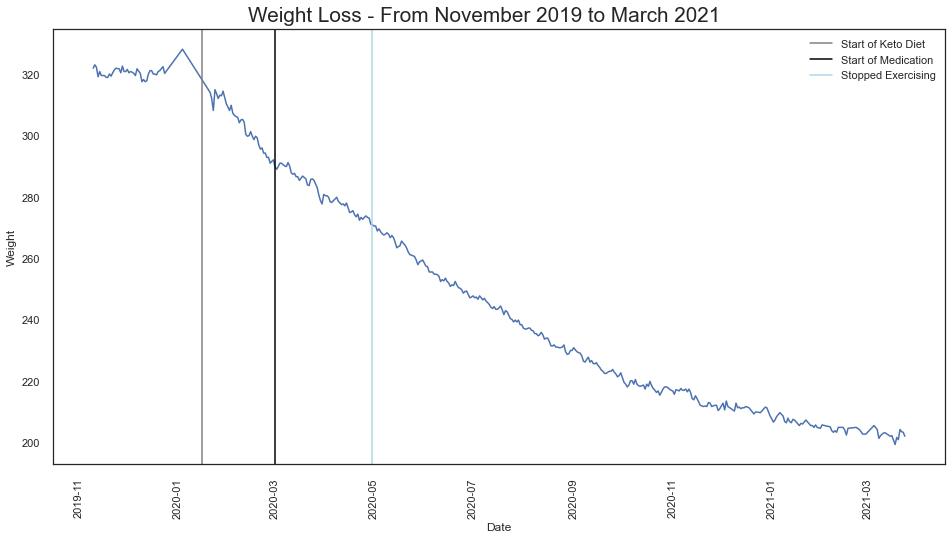

In [19]:
# Set theme and plot sizes
sns.set_theme(style="white")
plt.rcParams['figure.figsize'] = (16, 8)

# Plot line chart
plt.plot(df_1['date'],df_1['weight'])
plt.suptitle('Weight Loss - From November 2019 to March 2021', x=0.5, y= 0.92, ha='center', fontsize='xx-large')
plt.xlabel('Date')
plt.ylabel('Weight')
plt.axvline('2020-01-16', color='grey',label='Start of Keto Diet')
plt.axvline('2020-03-01', color='black', label = 'Start of Medication')
plt.axvline('2020-04-30', color='lightblue', label = 'Stopped Exercising')
plt.xticks(rotation=90)
plt.legend()
plt.show()

Text(0.5, 0.92, 'Weight Gain/Loss Distribution')

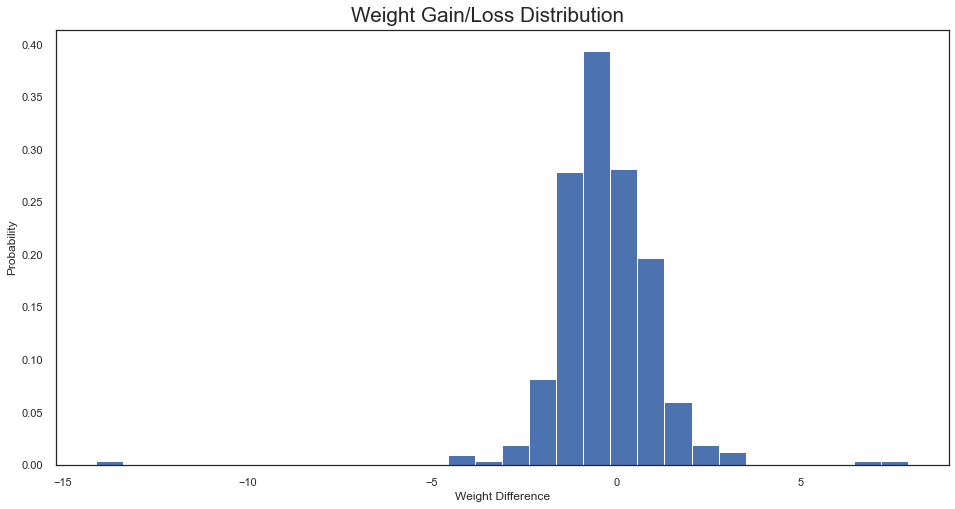

In [20]:
# Histogram for Weight Gain/Loss distribution
plt.hist(df_1['weight_diff'], bins=30, density=True)
plt.ylabel('Probability')
plt.xlabel('Weight Difference')
plt.suptitle('Weight Gain/Loss Distribution', x=0.5, y= 0.92, ha='center', fontsize='xx-large')

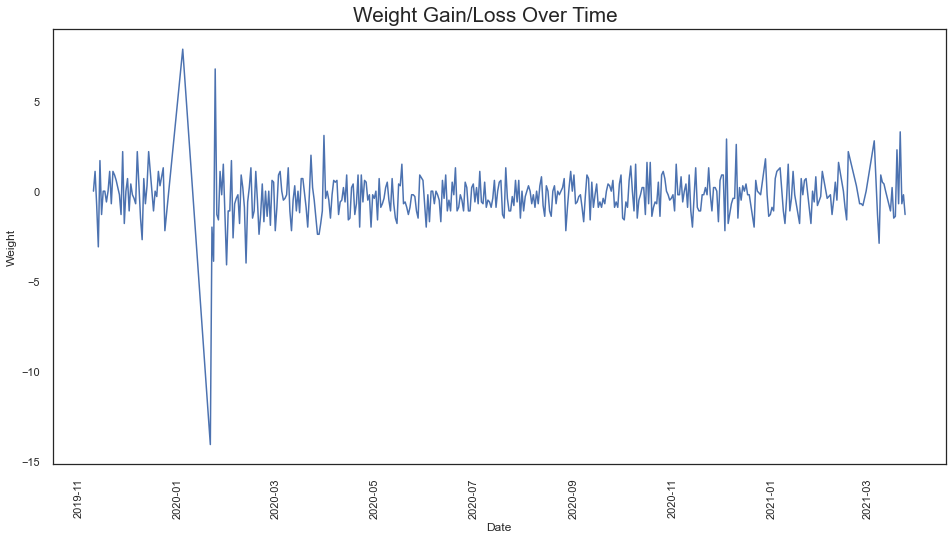

In [21]:
# Line Chart Weight Difference over Time
plt.plot(df_1['date'],df_1['weight_diff'])
plt.suptitle('Weight Gain/Loss Over Time', x=0.5, y= 0.92, ha='center', fontsize='xx-large')
plt.xlabel('Date')
plt.ylabel('Weight')
plt.xticks(rotation=90)
plt.show()

Text(0.5, 0.92, 'Weight Gain/Loss Over Time')

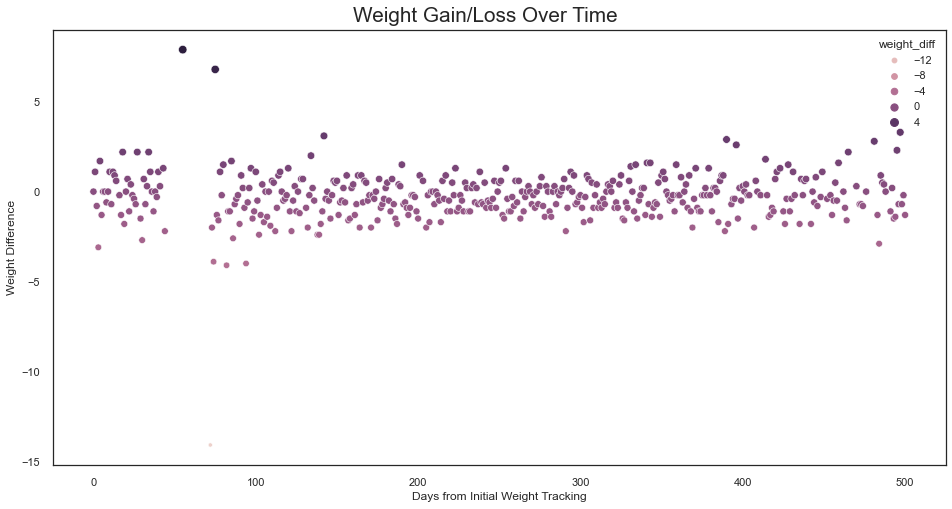

In [22]:
# Scatter Plot
sns.scatterplot(x="days_cum", y="weight_diff", data=df_1, hue="weight_diff", size='weight_diff')
sns.color_palette("mako", as_cmap=True)
plt.xlabel("Days from Initial Weight Tracking")
plt.ylabel("Weight Difference")
plt.suptitle('Weight Gain/Loss Over Time', x=0.5, y= 0.92, ha='center', fontsize='xx-large')

We have a gap of missing data starting on 01/05/2020 all the way up to 01/20/2020. Data capture resumes again on 01/21/2020. Notice that earnest weight loss efforts began around 01/10/2020. For the purposes of this experiment, we are going to remove the records prior to 01/21/2020.

In [23]:
# Dropping data for dates prior to 01-21-2020 and recalculating the effects
df_2 = df_1[df_1.date > '2020-01-20'].reset_index(drop=True)
df_2['days_diff'] = df_2['date'] - df_2['date'].shift()
df_2['days_diff'] = df_2['days_diff']/np.timedelta64(1,'D')
df_2['weight_diff'] = df_2['weight'] - df_2['weight'].shift()
df_2 = df_2.fillna(0)
df_2['days_cum'] = df_2['days_diff'].cumsum()

In [25]:
#Resulting Data-Frame Shape
print('Data-frame shape: ', df_2.shape)

(393, 14)


In [26]:
df_2.describe()

,weight,weekday,TotalMeals,IsKeto,Medication,Dosage,weight_diff,days_diff,days_cum
count,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000
mean,243.114249,2.916031,1.424936,0.989822,0.106870,0.053435,-0.285496,1.089059,202.796438
std,32.701001,1.997594,0.638948,0.100500,0.309342,0.154671,1.100403,0.428223,119.221151
min,199.200000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.100000,0.000000,0.000000
25%,214.200000,1.000000,1.000000,1.000000,0.000000,0.000000,-0.900000,1.000000,101.000000
50%,235.400000,3.000000,1.000000,1.000000,0.000000,0.000000,-0.300000,1.000000,201.000000
75%,270.500000,5.000000,2.000000,1.000000,0.000000,0.000000,0.400000,1.000000,299.000000
max,315.000000,6.000000,3.000000,1.000000,1.000000,0.500000,6.800000,5.000000,428.000000


Text(0.5, 0.92, 'Weight Gain/Loss Over Time')

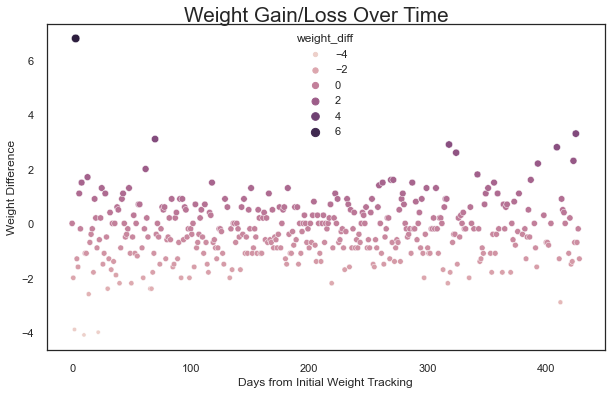

In [29]:
# Scatter Plot for revised data
plt.rcParams['figure.figsize'] = (10, 6)
sns.scatterplot(x="days_cum", y="weight_diff", data=df_2, hue="weight_diff", size='weight_diff')
sns.color_palette("mako", as_cmap=True)
plt.xlabel("Days from Initial Weight Tracking")
plt.ylabel("Weight Difference")
plt.suptitle('Weight Gain/Loss Over Time', x=0.5, y= 0.92, ha='center', fontsize='xx-large')

Text(0.5, 0.92, 'Weight Gain/Loss Distribution')

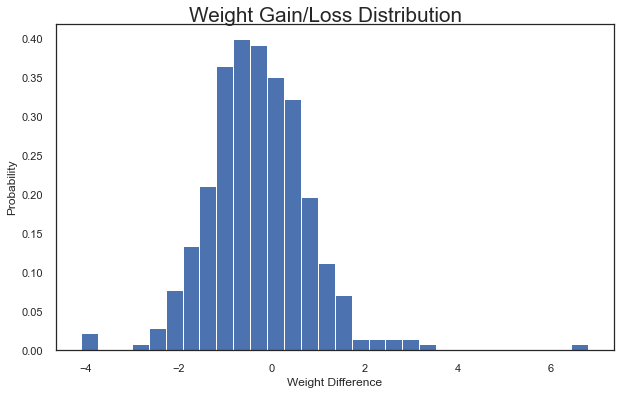

In [30]:
# Histogram for Weight Gain/Loss distribution
plt.rcParams['figure.figsize'] = (10, 6)
plt.hist(df_2['weight_diff'], bins=30, density=True)
plt.ylabel('Probability')
plt.xlabel('Weight Difference')
plt.suptitle('Weight Gain/Loss Distribution', x=0.5, y= 0.92, ha='center', fontsize='xx-large')

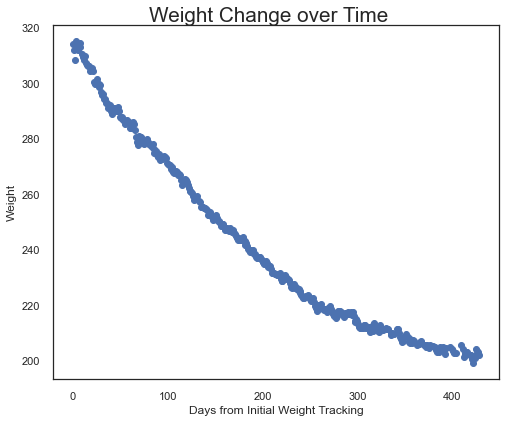

In [35]:
# Shape of Weight over Time
plt.rcParams['figure.figsize'] = (8, 6.5)
#mymodel = np.poly1d(np.polyfit(df_2['days_cum'], df_2['weight'], 3))
#myline = np.linspace(0, 450, 620)
plt.suptitle('Weight Change over Time', x=0.5, y= 0.92, ha='center', fontsize='xx-large')
plt.xlabel("Days from Initial Weight Tracking")
plt.ylabel("Weight")
plt.scatter(df_2['days_cum'], df_2['weight'])
#plt.plot(myline, mymodel(myline))
plt.show()

________________________
## Linear Regression

### Pearson's Ranking of Parameters

In [69]:
# Pearson's Ranking for Weight Difference as the Target Variable
feature = ['weekday', 'TotalMeals', 'IsKeto','Medication','Dosage','days_diff','days_cum','weight']
target = 'weight_diff'
X = df_2[feature]
y = df_2[target]

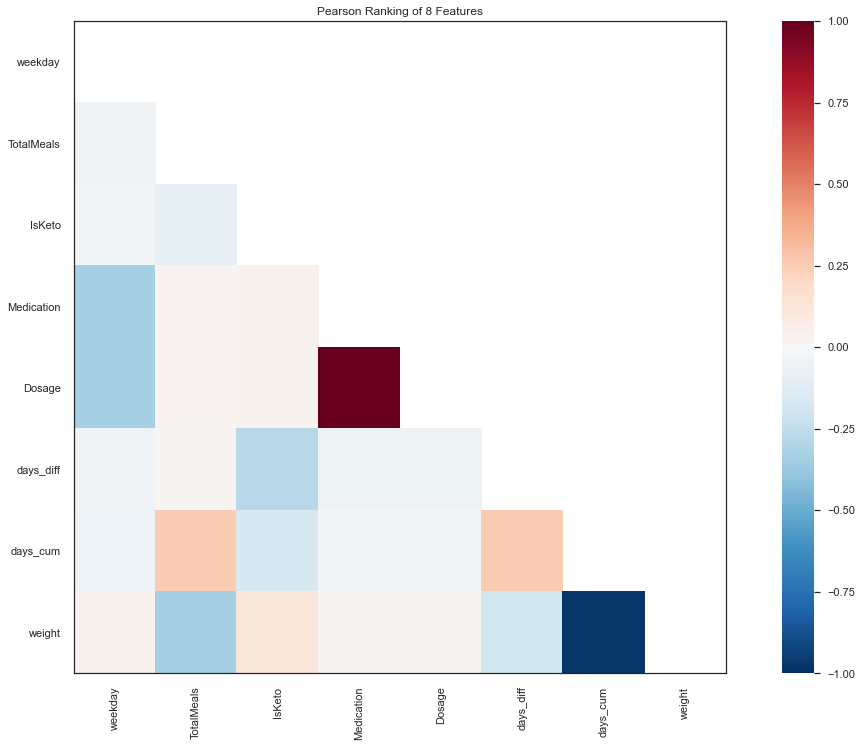

<AxesSubplot:title={'center':'Pearson Ranking of 8 Features'}>

In [71]:
plt.rcParams['figure.figsize'] = (20, 12)
visualizer = Rank2D(features=feature, algorithm='pearson')
visualizer.fit(X, y)                
visualizer.transform(X)             
visualizer.poof()

In [64]:
# Preparing the data for the model
model_x = df_2[['TotalMeals', 'IsKeto','Medication','Dosage','days_cum','weight','days_diff','weekday']]
model_y = df_2['weight_diff']

# Standardizing the features
model_X = StandardScaler().fit_transform(model_x)

# Split data into the training and testing at 70/30 ratio
X1_train, X1_val, y1_train, y1_val = train_test_split(model_X, model_y, test_size =0.3, random_state=11)

print("No. of samples in training set: ", X1_train.shape[0])
print("No. of samples in validation set:", X1_val.shape[0])

No. of samples in training set:  275
No. of samples in validation set: 118


In [65]:
#Save Raw values for another plot
X1_vals = X1_val

In [66]:
# Set PCA and apply
pca = PCA(.95)

pca.fit(X1_train)

X1_train = pca.transform(X1_train)
X1_val = pca.transform(X1_val)

# Model instance
linear = LinearRegression()

# Generate the model
linear.fit(X1_train,y1_train)

# Predict values
y_pred1=linear.predict(X1_val)

In [44]:
print('Intercept:\t', linear.intercept_)
print('Coefficients:\t', linear.coef_)
print('Mean Squared Error:\t', mean_squared_error(y1_val, y_pred1))
print('R^2:\t', r2_score(y1_val, y_pred1))

Intercept:	 -0.20945454545454503
Coefficients:	 [ 0.14491309  0.06999788  0.03653868 -0.04750541 -0.14651323  0.11993313]
Mean Squared Error:	 1.047661549510202
R^2:	 -0.05251442411723106


The Means Squared Error and R2 values indicate that a linear model is not the best fit for the data. 

Text(0, 0.5, 'Weight')

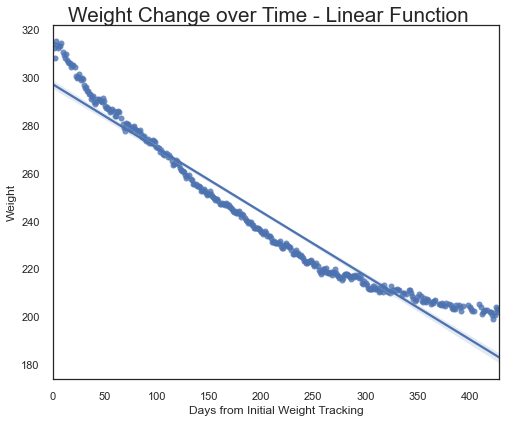

In [41]:
# Linear Regresssion chart for revised data
plt.rcParams['figure.figsize'] = (8, 6.5)
#plt.rcParams['figure.figsize'] = (15, 8)
sns.regplot(x="days_cum", y="weight", data=df_2)
plt.suptitle('Weight Change over Time - Linear Function', x=0.5, y= 0.92, ha='center', fontsize='xx-large')
plt.xlabel("Days from Initial Weight Tracking")
plt.ylabel("Weight")

In [ ]:
The Weight change over time resembles more of a curve than it does a line. 

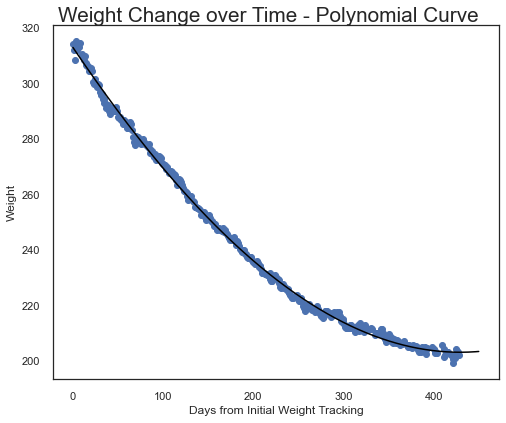

In [40]:
plt.rcParams['figure.figsize'] = (8, 6.5)
mymodel = np.poly1d(np.polyfit(df_2['days_cum'], df_2['weight'], 3))
myline = np.linspace(0, 450, 620)
plt.suptitle('Weight Change over Time - Polynomial Curve', x=0.5, y= 0.92, ha='center', fontsize='xx-large')
plt.xlabel("Days from Initial Weight Tracking")
plt.ylabel("Weight")
plt.scatter(df_2['days_cum'], df_2['weight'])
plt.plot(myline, mymodel(myline),color='black')
plt.show()

__________________________________________________
### Attempt #2 - Support Vector Regression using a Polynomial Kernel and Kernel Ridge Regression

Support Vector Machines operate using 4 different kernels:

1. Linear
2. Polynomial
3. Sigmoid
4. Gaussian

We've already established that the function follows that of a Polynomial curve, but let's take a look at each of these 4 kernels and see which one provides the best performance:

In [67]:
# Creating and Instancing the the Models
svrp = SVR(kernel='poly')
svrg = SVR(kernel='linear')
svrs = SVR(kernel='rbf')
svrl = SVR(kernel='sigmoid')


svrp.fit(X1_train,y1_train)
svrg.fit(X1_train,y1_train)
svrs.fit(X1_train,y1_train)
svrl.fit(X1_train,y1_train)

print("SVR Polynomial R^2 Score: ", svrp.score(X1_train,y1_train))
print("SVR Linear R^2 Score: ", svrg.score(X1_train,y1_train))
print("SVR Gaussian R^2 Score: ", svrs.score(X1_train,y1_train))
print("SVR Sigmoid R^2 Score: ", svrl.score(X1_train,y1_train))

SVR Polynomial R^2 Score:  0.1612812061991823
SVR Linear R^2 Score:  0.04993963721974681
SVR Gaussian R^2 Score:  0.12053943800447131
SVR Sigmoid R^2 Score:  -2.0454064533028427


In this case the Polynomial kernel provides us with the best predictive value using the available variables. However the R2 value provided by the winning mode is very low, meaning it has very poor predictive power.

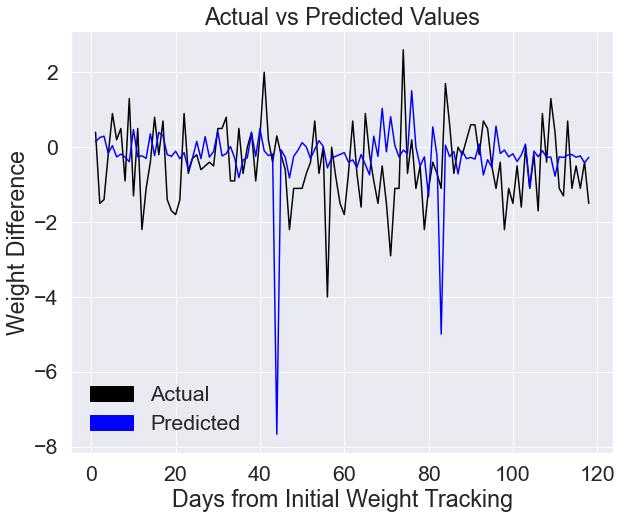

In [93]:
# Comparing predicted vs actual values
y_predp = svrp.predict(X1_val)
# Create a baseline x-axis
x_axis = []
for i in range(1,119):
    x_axis.append(i)

# Plotting the difference
plt.figure(figsize=(10, 8), dpi=70)
plt.plot(x_axis, y1_val, color='black')
plt.plot(x_axis, y_predp, color='blue')
plt.title('Actual vs Predicted Values')
plt.xlabel("Days from Initial Weight Tracking")
black_patch = mpatches.Patch(color='black', label='Actual')
blue_patch = mpatches.Patch(color='blue', label='Predicted')
plt.legend(handles=[black_patch,blue_patch])
plt.ylabel("Weight Difference")
plt.show()


_______________
## Reframing Weight Loss/Gain as a Classification Problem using Support Vector Machine

In [51]:
# Creating the classifier variable

# Function that returns a boolean response: 1 for weight gained or 0 for no weight gain/loss
def weight_gain(row):
    if row['weight_diff'] > 0:
        value = 1
    else:
        value = 0
    return value

In [52]:
df_2['weight_gain'] = df_2.apply(weight_gain, axis=1)

In [53]:
# Pearson's Ranking for Weight Gain classifier as the Target Variable
feature = ['weekday', 'TotalMeals', 'IsKeto','Medication','Dosage','days_diff','days_cum','weight']
target = 'weight_gain'
Xc = df_2[feature]
yc = df_2[target]

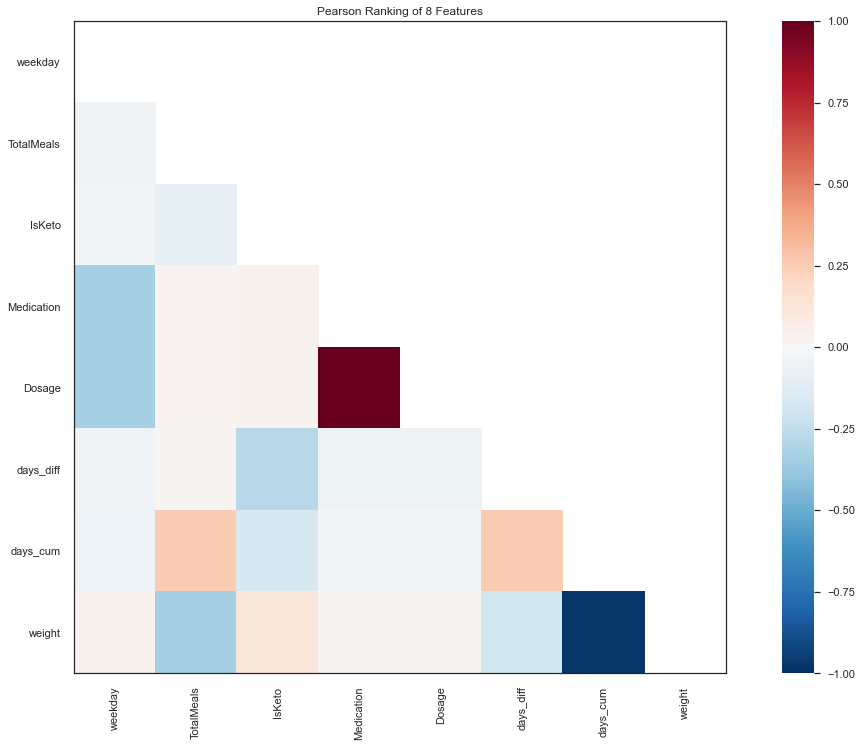

<AxesSubplot:title={'center':'Pearson Ranking of 8 Features'}>

In [54]:
# Generating Pearson's ranking - We notice it's exactly the same as with Weight Difference variable
plt.rcParams['figure.figsize'] = (20, 12)
visualizer = Rank2D(features=feature, algorithm='pearson')
visualizer.fit(Xc, yc)                
visualizer.transform(Xc)             
visualizer.poof()

In [55]:
# Splitting Test and Training Data using the same ratio as before. Setting new target variable
model_y1 = df_2['weight_gain']

X2_train, X2_val, y2_train, y2_val = train_test_split(model_X, model_y1, test_size =0.3, random_state=11)

In [56]:
print("No. of samples in training set: ", X2_train.shape[0])
print("No. of samples in validation set:", X2_val.shape[0])

No. of samples in training set:  275
No. of samples in validation set: 118


In [57]:
# Principal Componet Analysis on the new data
pca.fit(X2_train)

X2_train = pca.transform(X2_train)
X2_val = pca.transform(X2_val)

In [58]:
#Instance the model
clf = svm.SVC(kernel='poly')
# Create the model
clf.fit(X2_train, y2_train)
# Predict results using test data
y_pred = clf.predict(X2_val)
# Assess Model Accuracy
print("Accuracy:",metrics.accuracy_score(y2_val, y_pred))

Accuracy: 0.6864406779661016


<AxesSubplot:>

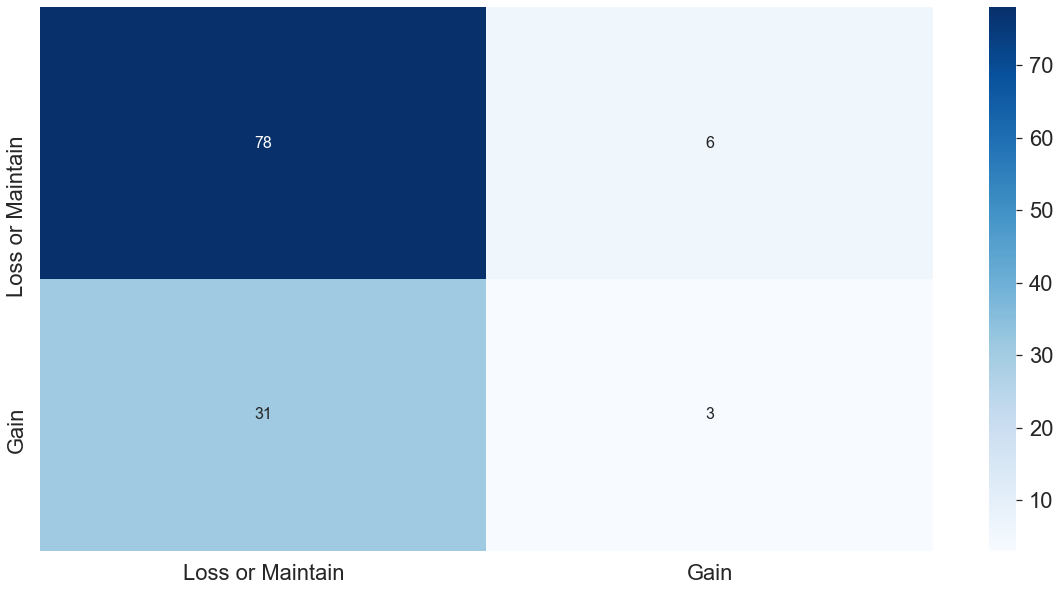

In [59]:
# Generate a confusion matrix using predicted y values against the y from the validation set
array = confusion_matrix(y2_val,y_pred)
# Create the classes - In this case Average against Best performance
classes = ['Loss or Maintain','Gain']
# Create a dataframe from the confusion matrix array and the the classes
df_cm = pd.DataFrame(array, index = [i for i in classes],
                  columns = [i for i in classes])
# Generate the visual matrix using a Seaborn Heat Map
plt.figure(figsize = (20,10))
sns.set(font_scale=2)
sns.set_palette("husl")
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="Blues", fmt='g')

<AxesSubplot:>

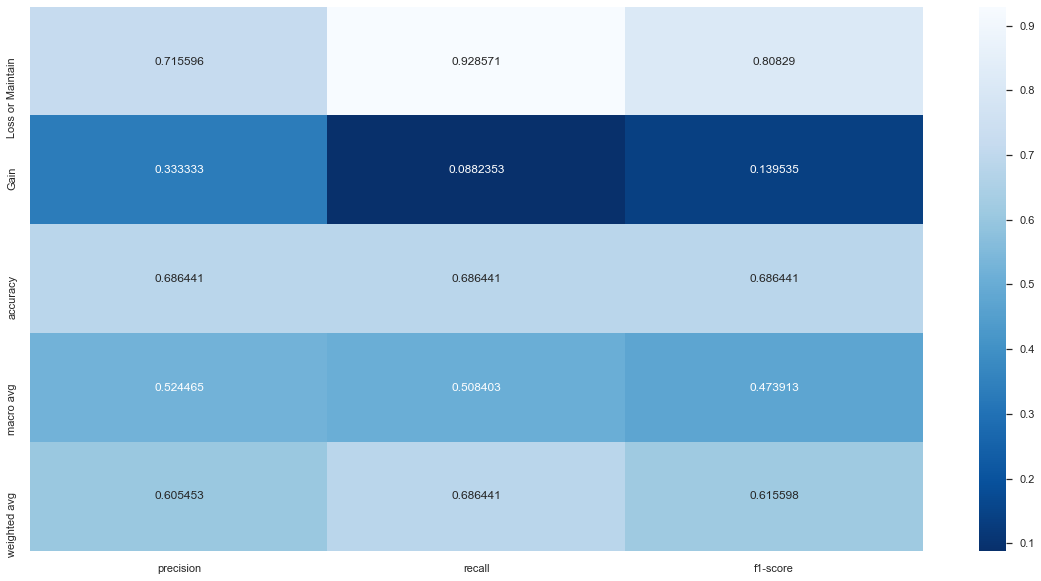

In [60]:
# Create the clasification report
clf_log = classification_report(y2_val,y_pred, target_names= classes, output_dict=True)
# Create the visualization
plt.figure(figsize = (20,10))
sns.set(font_scale=1)
sns.heatmap(pd.DataFrame(clf_log).iloc[:-1, :].T, annot=True, cmap="Blues_r", fmt='g')

The model is biased towards weight loss, meaning it mislabelled a good portion of the actual weight gain values as weight loss.

### Another classification attempt using Random Forest Classifier

In [61]:
rfc=RandomForestClassifier(n_estimators=500)

rfc.fit(X2_train, y2_train)

# Generate the predictions
y_pred=rfc.predict(X2_val)

print("Accuracy:",metrics.accuracy_score(y2_val, y_pred))

Accuracy: 0.6610169491525424


In [62]:
y_pred1 = clf.predict(X2_val)

## Conclusion

Support Vector Regression/Machine with polynomial kernel provide the best odds of determining weight gain/loss. A more robust dataset with more defined variables and better correlation values will potentially yield better results.